In [5]:
import numpy as np
from numba import njit
from time import time
import benchit

Bolt programėlė fiksuoja kiekvieno kurjerio ID ir kiekvienos dienos uždirbtą pinigų sumą. Duomenų bazė saugoma serveryje. Atlikus tam tikrą jos užklausą gaunama dviejų stulpelių lentelė. Jos pirmame stulpelyje yra įrašytas kurjerio unikalus ID, o antroje - uždirbtos pinigų sumos skirtingomis dienomis. Raskite kiekvieno kurjerio visas uždirbtas sumas.

### Input

    N = 20
    x1 = np.random.randint(67, 73, size=N)
    x2 = np.random.normal(loc=50, scale=20, size=N).astype(int)
    X = np.transpose([x1, x2])

or:

In [25]:
X = np.array([[69, 61],
               [67, 68],
               [70, 41],
               [70, 70],
               [71, 68],
               [70, 58],
               [67, 90],
               [68, 80],
               [72, 11],
               [67, 19],
               [70, 32],
               [70, 53],
               [68, 68],
               [69, 49],
               [67, 89],
               [70, 70],
               [68, 48],
               [67, 59],
               [72, 72],
               [70, 67]])

### Expected output

    {67: array([19, 68, 59, 89, 90]),
     68: array([48, 80, 68]),
     69: array([49, 61]),
     70: array([32, 53, 58, 70, 70, 41, 67]),
     71: array([68]),
     72: array([11, 72])}

## Solutions

In [26]:
def _custom_return(unique_id, a, split_idx, return_groups):
    if return_groups:
        return unique_id, np.split(a[:,1], split_idx)
    else: 
        return np.split(a[:,1], split_idx)

Visi greitai veikiantys sprendimai naudoja rūšiavimą pagal pirmą stulpelį:

In [27]:
a = X[X[:, 0].argsort()]

### Solution 1A: `np.unique` with `return_index=True`

In [29]:
def numpy_groupby_index(a, return_groups=False):
    u, idx = np.unique(a[:,0], return_index=True) 
    return _custom_return(u, a, idx[1:], return_groups)

dict(zip(*numpy_groupby_index(a, return_groups=True)))

{67: array([19, 68, 59, 89, 90]),
 68: array([48, 80, 68]),
 69: array([49, 61]),
 70: array([32, 53, 58, 70, 70, 41, 67]),
 71: array([68]),
 72: array([11, 72])}

### Solution 1B: `np.unique` with `return_counts=True`

In [30]:
def numpy_groupby_counts(a, return_groups=False):
    u, counts = np.unique(a[:,0], return_counts=True)
    idx = np.cumsum(counts)
    return _custom_return(u, a, idx[:-1], return_groups)
dict(zip(*numpy_groupby_counts(a, return_groups=True)))

{67: array([19, 68, 59, 89, 90]),
 68: array([48, 80, 68]),
 69: array([49, 61]),
 70: array([32, 53, 58, 70, 70, 41, 67]),
 71: array([68]),
 72: array([11, 72])}

### Solution 2: `np.flatnonzero` on `np.diff`

In [31]:
def numpy_groupby_diff(a, return_groups=False):
    u = np.unique(a[:,0])
    idx = np.flatnonzero(np.diff(a[:,0])) + 1
    return _custom_return(u, a, idx, return_groups)
dict(zip(*numpy_groupby_diff(a, return_groups=True)))

{67: array([19, 68, 59, 89, 90]),
 68: array([48, 80, 68]),
 69: array([49, 61]),
 70: array([32, 53, 58, 70, 70, 41, 67]),
 71: array([68]),
 72: array([11, 72])}

### Solution 3A: `np.bincount` which is much better for small unique IDs

In [32]:
def numpy_groupby_bins(a, return_groups=False):  
    bins = np.bincount(a[:,0])
    nonzero_bins_idx = bins != 0
    nonzero_bins = bins[nonzero_bins_idx]
    idx = np.cumsum(nonzero_bins[:-1])
    return _custom_return(np.flatnonzero(nonzero_bins_idx), a, idx, return_groups)
dict(zip(*numpy_groupby_bins(a, return_groups=True)))

{67: array([19, 68, 59, 89, 90]),
 68: array([48, 80, 68]),
 69: array([49, 61]),
 70: array([32, 53, 58, 70, 70, 41, 67]),
 71: array([68]),
 72: array([11, 72])}

### Solution 3B: `np.bincount` in nopython mode

In [33]:
@njit
def __numba_bincount(a, counts, m):
    for i in range(m):
        counts[a[i]] += 1

def _numba_bincount(arr): #just a refactor of Python count
    M = np.max(arr)
    counts = np.zeros(M + 1, dtype=int)
    __numba_bincount(arr, counts, len(arr))
    return counts

_numba_bincount(np.array([2,3,2,1,5,5,5,2]))

array([0, 1, 3, 1, 0, 3])

In [34]:
def numba_groupby_bins(a, return_groups=False):  
    bins = _numba_bincount(a[:,0])
    nonzero_bins_idx = bins != 0
    nonzero_bins = bins[nonzero_bins_idx]
    idx = np.cumsum(nonzero_bins[:-1])
    return _custom_return(np.flatnonzero(nonzero_bins_idx), a, idx, return_groups)
dict(zip(*numba_groupby_bins(a, return_groups=True)))

{67: array([19, 68, 59, 89, 90]),
 68: array([48, 80, 68]),
 69: array([49, 61]),
 70: array([32, 53, 58, 70, 70, 41, 67]),
 71: array([68]),
 72: array([11, 72])}

### Timings

SORTING... 30.87


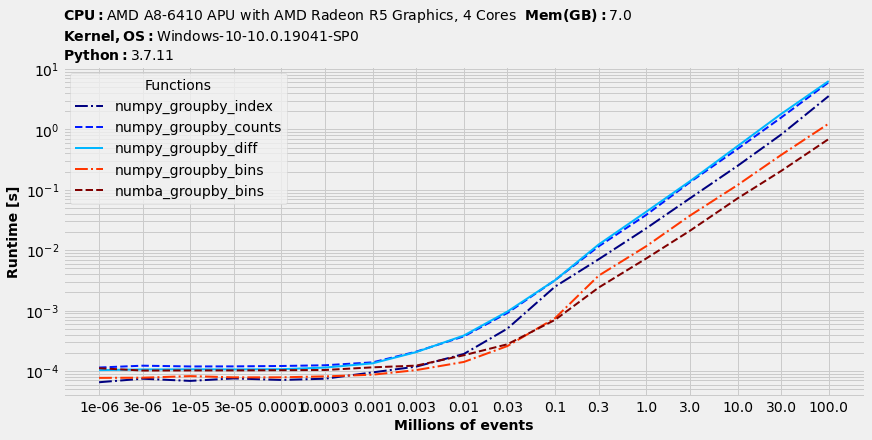

In [32]:
%matplotlib inline
benchit.setparams(rep=3)

sizes = [3*10**(i//2) if i%2 else 10**(i//2) for i in range(17)]
N = sizes[-1]
x1 = np.random.randint(0,10, size=N)
x2 = np.random.normal(loc=500, scale=200, size=N).astype(int)
a = np.transpose([x1, x2])

arr = a[a[:, 0].argsort()]

fns = [numpy_groupby_index, numpy_groupby_counts, numpy_groupby_diff, numpy_groupby_bins, numba_groupby_bins]
in_ = {s/1000000: (arr[:s], ) for s in sizes}
t = benchit.timings(fns, in_, multivar=True, input_name='Millions of events')
t.plot(logx=True, figsize=(12, 6), fontsize=14)